In [ ]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')



Mounted at /content/drive


In [ ]:
#import my_utils as mu
import torch
from torch import nn
import torch.utils.data as data_utils
from IPython import display
import math
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader



In [ ]:
ltc_data = pd.read_csv('/content/drive/MyDrive/Data/type1d_ltc.txt',
                       sep='\t', header=None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Load the data

In [ ]:
ltc_data.columns = ltc_data.iloc[0]
data2 = ltc_data.drop(ltc_data.index[0])
data2

,patid,dob,eventdate,term,ltc
1,210235,1920-01-01,1993-08-12,Hypertension,1
2,210235,1920-01-01,1996-12-30,Coronary heart disease,1
3,210235,1920-01-01,1987-01-01,Unspecified or Rare Diabetes,1
4,210235,1920-01-01,1999-05-20,Coronary heart disease,1
5,210235,1920-01-01,2004-05-12,Diabetic eye disease,1
...,...,...,...,...,...
6088438,10172510229,1961-01-01,2013-09-17,Coronary heart disease,1
6088439,10172510229,1961-01-01,2020-03-02,Coronary heart disease,1
6088440,10178710229,1941-01-01,2017-09-01,Urolithiasis,1
6088441,10207110229,1930-01-01,2003-12-02,Diabetic eye disease,1


Assign new variable - patient age at time of event. This is calculated by subtracting dob from eventdate

In [ ]:
data2 = data2.assign(age_at_event = 
                     data2['eventdate'].str[0:4].astype(int)
                      - data2['dob'].str[0:4].astype(int))


See when the data was collected by finding the earliest and latest eventdate

In [ ]:
eventdate_sort = data2.sort_values(by=['eventdate'])
eventdate_sort

,patid,dob,eventdate,term,ltc,age_at_event
1099802,3292610558,1925-01-01,1925-10-21,Chronic Kidney Disease,1,0
1031556,2619510641,1926-01-01,1926-07-19,Obesity,1,0
617383,1008810260,1921-01-01,1928-01-01,Tuberculosis,1,7
1100301,3302610558,1928-01-01,1928-06-30,Hypertension,1,0
1100304,3302610558,1928-01-01,1928-06-30,Unspecified or Rare Diabetes,1,0
...,...,...,...,...,...,...
2607989,1349910152,1949-01-01,2021-07-16,Constipation,1,72
2607984,1349910152,1949-01-01,2021-08-13,Painful conditions,1,72
2607990,1349910152,1949-01-01,2021-08-13,Constipation,1,72
2607985,1349910152,1949-01-01,2021-09-10,Painful conditions,1,72


From the above df we can see that the records dates between 21/10/1925 and 10/09/2021.


As ltc seems to indicate whether they have a longterm condition (which should apply to everyone in the dataset) we can check whether every value is the same for that column and, if so, remove the colum.

In [ ]:
data2.ltc.unique()
data3 = data2.drop(['eventdate', 'ltc'], axis=1)

data3

,patid,dob,term,age_at_event
1,210235,1920-01-01,Hypertension,73
2,210235,1920-01-01,Coronary heart disease,76
3,210235,1920-01-01,Unspecified or Rare Diabetes,67
4,210235,1920-01-01,Coronary heart disease,79
5,210235,1920-01-01,Diabetic eye disease,84
...,...,...,...,...
6088438,10172510229,1961-01-01,Coronary heart disease,52
6088439,10172510229,1961-01-01,Coronary heart disease,59
6088440,10178710229,1941-01-01,Urolithiasis,76
6088441,10207110229,1930-01-01,Diabetic eye disease,73


To simplify the dataset, we will only keep the first instance of each ltc. To do this, we can sort the df by age_at_event and drop any instance which is a duplicate of both patient id (patid) AND long term condition (term), while keeping only the first instance (earliest).

In [ ]:
data4 = data3.sort_values(by=['age_at_event'])
data4['patid'] = data4['patid'].apply(int)
data4 = data4.drop_duplicates(subset=['term', 'patid'], keep="first")
data4 = data4.sort_index()
#data4.set_index('patid')
data4

,patid,dob,term,age_at_event
1,210235,1920-01-01,Hypertension,73
2,210235,1920-01-01,Coronary heart disease,76
10,210235,1920-01-01,Unspecified or Rare Diabetes,67
11,210235,1920-01-01,Female genital prolapse,71
14,210235,1920-01-01,Urinary Incontinence,72
...,...,...,...,...
6087675,9147410229,1948-01-01,Retinal detachments and breaks,62
6087688,9474410644,1994-01-01,Fracture of hip,10
6088436,10168410229,1933-01-01,Coronary heart disease,78
6088440,10178710229,1941-01-01,Urolithiasis,76


To see whether to change all NaN values to 0 or some other value (once we pivot the table), we checked to see if any diagnosis was taken at age 0.

In [ ]:
age0 = data4.loc[data4['age_at_event'].values == 0]
age0

,patid,dob,term,age_at_event
553,1110018,1951-01-01,Hearing loss,0
6617,9910593,1933-01-01,Seborrheic dermatitis,0
8583,13510030,1993-01-01,Seborrheic dermatitis,0
10966,16010442,1993-01-01,Asthma,0
12792,18510765,1988-01-01,Epilepsy,0
...,...,...,...,...
2241945,855910128,1992-01-01,Painful conditions,0
2437594,1109410448,1990-01-01,Painful conditions,0
2632415,1391810206,1990-01-01,Painful conditions,0
2664323,1451210266,1992-01-01,Painful conditions,0


As there were events at age 0 it is not appropriate to change all NaN values to 0.

Below we check patients to ensure that all duplicates have been removed by displaying that patients records before removing duplicates and after.

In [ ]:
pat_1110018_pre = data3.loc[data3['patid'].values == 1110018]
pat_1110018_pre

,patid,dob,term,age_at_event
3294159,1110018,1951-01-01,Thyroid disease,53
3294160,1110018,1951-01-01,Osteoarthritis (excl spine),60
3294161,1110018,1951-01-01,Type 2 Diabetes,61
3294162,1110018,1951-01-01,Thyroid disease,61
3294163,1110018,1951-01-01,Type 1 Diabetes,65
3294164,1110018,1951-01-01,Thyroid disease,68
3294165,1110018,1951-01-01,Type 1 Diabetes,68
3294166,1110018,1951-01-01,Chronic sinusitis,68
3294167,1110018,1951-01-01,Nasal polyp,68
5810887,1110018,1951-01-01,Chronic sinusitis,53


In [ ]:
pat_1110018_post = data4.loc[data4['patid'].values == 1110018]
pat_1110018_post

,patid,dob,term,age_at_event
552,1110018,1951-01-01,Chronic sinusitis,8
553,1110018,1951-01-01,Hearing loss,0
554,1110018,1951-01-01,Thyroid disease,19
555,1110018,1951-01-01,Spondylosis,35
563,1110018,1951-01-01,Dermatitis (atopc/contact/other/unspecified),56
564,1110018,1951-01-01,Enthesopathies & synovial disorders,56
566,1110018,1951-01-01,Somatoform and dissociative disorders,57
570,1110018,1951-01-01,Type 1 Diabetes,61
571,1110018,1951-01-01,Unspecified or Rare Diabetes,61
3294160,1110018,1951-01-01,Osteoarthritis (excl spine),60


Before we create a pivot table we remove the date of birth column (dob) as it will no longer be needed and will create issues with duplicate values for each patient.

In [ ]:
dataset = data4.drop(['dob'], axis=1)
dataset



,patid,term,age_at_event
1,210235,Hypertension,73
2,210235,Coronary heart disease,76
10,210235,Unspecified or Rare Diabetes,67
11,210235,Female genital prolapse,71
14,210235,Urinary Incontinence,72
...,...,...,...
6087675,9147410229,Retinal detachments and breaks,62
6087688,9474410644,Fracture of hip,10
6088436,10168410229,Coronary heart disease,78
6088440,10178710229,Urolithiasis,76


In [ ]:
conditions = dataset['term'].unique()
conditions.sort()
conditions

array(['ADHD and hyperkinetic disorders',
       "Adrenal insufficiency and Addison's disease",
       'Alcohol dependence and related disease',
       'Allergic and chronic rhinitis',
       'Alopecia areata and scarring alopecia', 'Ankylosing spondylitis',
       'Anxiety and phobia', 'Aortic aneurysm', 'Aplastic anaemias',
       'Asbestosis', 'Asthma', 'Atrial fibrillation and flutter',
       "Autism and Asperger's syndrome", 'Autoimmune liver disease',
       "Barrett's oesophagus", 'Bipolar affective disorder and mania',
       'Blistering autoimmune skin conditions', 'Bronchiectasis', 'COPD',
       'Cardiac conduction defects', 'Cardiomyopathy other',
       'Cerebral Palsy', 'Cerebrovascular disease',
       'Cervical carcinoma in situ', 'Cholelithiasis',
       'Chronic Kidney Disease', 'Chronic fatigue', 'Chronic sinusitis',
       'Chronic ulcer of the skin', 'Chronic viral hepatitis',
       'Coeliac disease', 'Collapsed vertebra',
       'Congenital cardiac disease', 'Co

Now pivot table is created with patient id (patid) as the index, a seperate column for each long term condidion (term), and age at event as the value.

In [ ]:
dataset_p = dataset.pivot(index='patid', columns='term', 
                          values='age_at_event')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 649487 entries, 1 to 6088442
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   patid         649487 non-null  int64 
 1   term          649487 non-null  object
 2   age_at_event  649487 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 19.8+ MB


In [ ]:
dataset_p

term,ADHD and hyperkinetic disorders,Adrenal insufficiency and Addison's disease,Alcohol dependence and related disease,Allergic and chronic rhinitis,Alopecia areata and scarring alopecia,Ankylosing spondylitis,Anxiety and phobia,Aortic aneurysm,Aplastic anaemias,Asbestosis,...,Type 2 Diabetes,Ulcerative colitis,Unspecified or Rare Diabetes,Urinary Incontinence,Urolithiasis,Urticaria,Venous thromboembolism,Visual impairment and blindness,"Vitamin B12 deficiency, with and without anaemia",Vitiligo
patid,,,,,,,,,,,,,,,,,,,,,
210235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.0,NaN,67.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN
210260,NaN,NaN,66.0,NaN,NaN,NaN,71.0,54.0,NaN,NaN,...,58.0,NaN,70.0,68.0,55.0,NaN,54.0,67.0,70.0,NaN
210376,NaN,NaN,NaN,44.0,NaN,NaN,NaN,NaN,NaN,NaN,...,51.0,NaN,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
510099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,70.0,NaN,70.0,NaN,59.0,NaN,NaN,NaN,57.0,NaN
510124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.0,NaN,58.0,NaN,NaN,NaN,NaN,83.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10178710229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,64.0,NaN,65.0,79.0,76.0,NaN,79.0,67.0,NaN,NaN
10207110229,NaN,NaN,NaN,NaN,NaN,NaN,87.0,NaN,NaN,NaN,...,63.0,NaN,63.0,NaN,NaN,NaN,NaN,80.0,NaN,NaN
10225610229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The distribution of the average age to be diagnosed across all conditions can be seen below.

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


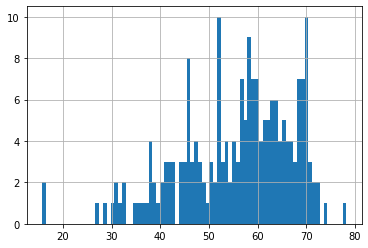

In [ ]:
dataset_p_w_average = dataset_p[:]
dataset_p_w_average.loc['mean'] = dataset_p_w_average.mean(axis=0)
dataset_average = dataset_p_w_average.loc['mean']
dataset_average.hist(bins = 80)

The dataset is then coded into binary variables by changing any real number to a 1, and all NaN values to 0. Now if the condition is present it is represented by a 1 and if it's absent it's represented by 0.

In [ ]:
dataset_p_bin = dataset_p[:]
dataset_p_bin[:] = np.where(dataset_p_bin>-1,1,0)
dataset_p_bin


term,ADHD and hyperkinetic disorders,Adrenal insufficiency and Addison's disease,Alcohol dependence and related disease,Allergic and chronic rhinitis,Alopecia areata and scarring alopecia,Ankylosing spondylitis,Anxiety and phobia,Aortic aneurysm,Aplastic anaemias,Asbestosis,...,Type 2 Diabetes,Ulcerative colitis,Unspecified or Rare Diabetes,Urinary Incontinence,Urolithiasis,Urticaria,Venous thromboembolism,Visual impairment and blindness,"Vitamin B12 deficiency, with and without anaemia",Vitiligo
patid,,,,,,,,,,,,,,,,,,,,,
210235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
210260,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
210376,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
510099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
510124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10178710229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
10207110229,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10225610229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
MM_bin = dataset_p_bin
path = '/content/drive/MyDrive/Data/MM_bin'
torch.save(MM_bin, path)

We can now see total number of conditions for each participant by summing each row and creating a new column 'total_conditions'

In [ ]:
dataset_p_tot_cond = dataset_p_bin[:]
dataset_p_tot_cond['total_conditions'] = dataset_p.sum(axis = 1)
dataset_p_tot_cond

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


term,ADHD and hyperkinetic disorders,Adrenal insufficiency and Addison's disease,Alcohol dependence and related disease,Allergic and chronic rhinitis,Alopecia areata and scarring alopecia,Ankylosing spondylitis,Anxiety and phobia,Aortic aneurysm,Aplastic anaemias,Asbestosis,...,Ulcerative colitis,Unspecified or Rare Diabetes,Urinary Incontinence,Urolithiasis,Urticaria,Venous thromboembolism,Visual impairment and blindness,"Vitamin B12 deficiency, with and without anaemia",Vitiligo,total_conditions
patid,,,,,,,,,,,,,,,,,,,,,
210235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
210260,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,102.0
210376,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
510099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0
510124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10178710229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,24.0
10207110229,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,25.0
10225610229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [ ]:
print('the maximum number of conditions a patient has been diagnosed with is ',
      dataset_p_tot_cond['total_conditions'].max())
print('the minimum number of conditions a patient has been diagnosed with is ',
      dataset_p_tot_cond['total_conditions'].min())
print('the mean number of conditions a patient has been diagnosed with is ',
      dataset_p_tot_cond['total_conditions'].mean())

the maximum number of conditions a patient has been diagnosed with is  127.0
the minimum number of conditions a patient has been diagnosed with is  2.0
the mean number of conditions a patient has been diagnosed with is  16.04900046949517


In [ ]:
dataset_p_tot_cond_fift_plus = dataset_p_tot_cond[dataset_p_tot_cond['total_conditions']>55]
dataset_p_tot_cond_fift_plus

term,ADHD and hyperkinetic disorders,Adrenal insufficiency and Addison's disease,Alcohol dependence and related disease,Allergic and chronic rhinitis,Alopecia areata and scarring alopecia,Ankylosing spondylitis,Anxiety and phobia,Aortic aneurysm,Aplastic anaemias,Asbestosis,...,Ulcerative colitis,Unspecified or Rare Diabetes,Urinary Incontinence,Urolithiasis,Urticaria,Venous thromboembolism,Visual impairment and blindness,"Vitamin B12 deficiency, with and without anaemia",Vitiligo,total_conditions
patid,,,,,,,,,,,,,,,,,,,,,
210260,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,102.0
47910599,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,100.0
74310198,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,106.0
117210022,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,125.0
246410251,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,61.0
356810022,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,118.0
381410428,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,59.0
394210765,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,103.0
588710426,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,125.0


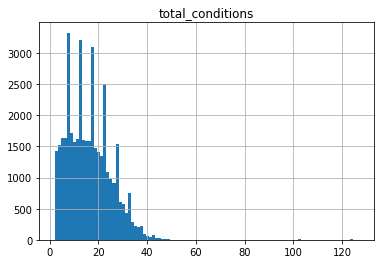

In [ ]:
fig = dataset_p_tot_cond.hist(column = ['total_conditions'], bins = 100)

In [ ]:
'''#get disease prevelece
dataset.loc['Total'] = dataset.sum()
dataset.loc['Percent'] = (dataset.loc['Total'] / len(dataset))*100

#drop columns below 2%
for col in dataset:
    # get the maximum value in column
    # check if it is less than or equal to the defined threshold
    if dataset.loc['Percent'][col] < 2:
        # if true, drop the column
        dataset = dataset.drop([col], axis=1)

#dataset'''

"#get disease prevelece\ndataset.loc['Total'] = dataset.sum()\ndataset.loc['Percent'] = (dataset.loc['Total'] / len(dataset))*100\n\n#drop columns below 2%\nfor col in dataset:\n    # get the maximum value in column\n    # check if it is less than or equal to the defined threshold\n    if dataset.loc['Percent'][col] < 2:\n        # if true, drop the column\n        dataset = dataset.drop([col], axis=1)\n\n#dataset"

In [ ]:
dataset_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40469 entries, 210235 to 10505010229
Columns: 204 entries, ADHD and hyperkinetic disorders to Vitiligo
dtypes: float64(204)
memory usage: 63.3 MB


In [ ]:
pat_data = pd.read_csv('/content/drive/MyDrive/Data/type1d_patients.csv',
                       sep=',', header=None)

In [ ]:
pat_data

,0,1,2,3,4,5,6,7,8,9
0,patid,gender,yob,mob,dob,ethnicity,eth_group,imd_decile,imd_quintile,dod
1,942810001,Male,1945,0,1945-01-01,White,White,3,2,NaN
2,954410001,Male,1969,0,1969-01-01,White,White,1,1,NaN
3,983110001,Male,1949,0,1949-01-01,White,White,1,1,NaN
4,1014510001,Male,1967,0,1967-01-01,NaN,Unknown,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...
40465,997510921,Female,1977,0,1977-01-01,White,White,8,4,NaN
40466,1759610921,Male,1935,0,1935-01-01,White,White,9,5,20121215
40467,2172710921,Female,1954,0,1954-01-01,White,White,3,2,20180428
40468,564410934,Male,1988,0,1988-01-01,White,White,6,3,NaN


In [ ]:
pat_data

pat_data.columns = pat_data.iloc[0]
pat_data2 = pat_data.drop(pat_data.index[0])
pat_data2['patid'] = pat_data2['patid'].apply(int)
pat_data2 = pat_data2.set_index('patid')

d = {'Male': 1, 'Female': 0}

pat_data2['gender'] = pat_data2['gender'].map(d)


pat_data2

pat_data2['gender'].value_counts()

1    22055
0    18414
Name: gender, dtype: int64

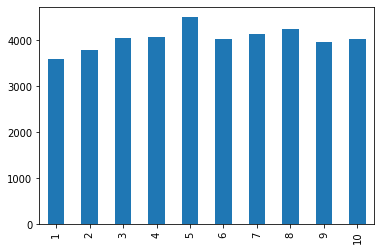

In [ ]:
imd_decile = pat_data2['imd_decile']
imd_decile = pd.Categorical(imd_decile,
                            categories=["1", "2", "3","4", "5",
                                        "6", "7", "8", "9", "10"],
                            ordered=True)
imd_decile.value_counts().plot.bar()

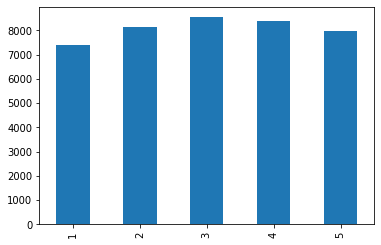

In [ ]:
imd_quintile = pat_data2['imd_quintile']
imd_quintile = pd.Categorical(imd_quintile, 
                              categories=["1", "2", "3","4", "5"], 
                              ordered=True)
imd_quintile.value_counts().plot.bar()

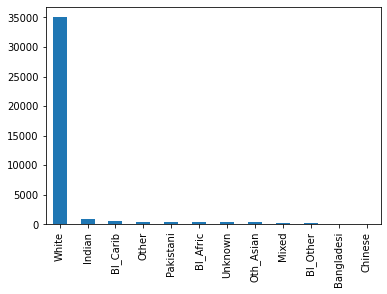

In [ ]:
ethnicity = pat_data2['ethnicity']

ethnicity.value_counts().plot.bar()

In [ ]:
ethnicity.value_counts()

White         35012
Indian          876
Bl_Carib        546
Other           494
Pakistani       489
Bl_Afric        407
Unknown         384
Oth_Asian       379
Mixed           291
Bl_Other        208
Bangladesi      147
Chinese          80
Name: ethnicity, dtype: int64

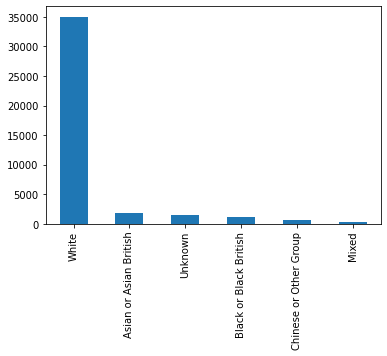

In [ ]:
eth_group = pat_data2['eth_group']

eth_group.value_counts().plot.bar()

In [ ]:
eth_group.value_counts()

White                     35012
Asian or Asian British     1891
Unknown                    1540
Black or Black British     1161
Chinese or Other Group      574
Mixed                       291
Name: eth_group, dtype: int64

In [ ]:
full_data = dataset_p_bin.join(pat_data2)
full_data = full_data.drop(['dob', 'mob'], axis=1)
full_data = full_data.drop(['dod'], axis=1)
full_data = full_data.drop(['yob', 'ethnicity', 'eth_group', 'imd_decile',
                            'imd_quintile', 'gender'], axis=1)


#full_data = full_data.drop(['Total', 'Percent'])
full_data = full_data.to_numpy()
full_data






array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
full_data_wp = dataset_p_bin.join(pat_data2)
full_data_wp = full_data_wp.drop(['dob', 'mob'], axis=1)
full_data_wp = full_data_wp.drop(['dod'], axis=1)
full_data_wp = full_data_wp.drop(['yob'], axis=1)

MM_data_wp = full_data_wp
path = '/content/drive/MyDrive/Data/MM_data_wp'
torch.save(MM_data_wp, path)

In [ ]:
full_data_tens = torch.from_numpy(full_data)
full_data_tens = full_data_tens.type(torch.FloatTensor)
#train = data_utils.TensorDataset(full_data)
MM_tens_data = full_data_tens
path = '/content/drive/MyDrive/Data/MM_tens_data'
torch.save(MM_tens_data, path)


In [ ]:
train_data, test_data = torch.utils.data.random_split(full_data_tens, [30000,
                                                                       10469])


In [ ]:
train_data

In [ ]:
test_data

In [ ]:
'''MM_test_data = test_data
path = '/content/drive/MyDrive/Data/MM_test_data'
torch.save(MM_test_data, path)'''

"MM_test_data = test_data\npath = '/content/drive/MyDrive/Data/MM_test_data'\ntorch.save(MM_test_data, path)"

In [ ]:
'''MM_train_data = train_data
path = '/content/drive/MyDrive/Data/MM_train_data'
torch.save(MM_train_data, path)'''

"MM_train_data = train_data\npath = '/content/drive/MyDrive/Data/MM_train_data'\ntorch.save(MM_train_data, path)"

In [ ]:
path = '/content/drive/MyDrive/Data/MM_train_data'
training_dataset = torch.load(path)

In [ ]:
training_dataset[1]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0.])

# Create Continuous Dataset

In [ ]:
dataset_p2_non_bin = dataset.pivot(index='patid', columns='term', 
                          values='age_at_event')
dataset_p2_non_bin.fillna(999,inplace=True)


In [ ]:
dataset_p2_non_bin

term,ADHD and hyperkinetic disorders,Adrenal insufficiency and Addison's disease,Alcohol dependence and related disease,Allergic and chronic rhinitis,Alopecia areata and scarring alopecia,Ankylosing spondylitis,Anxiety and phobia,Aortic aneurysm,Aplastic anaemias,Asbestosis,...,Type 2 Diabetes,Ulcerative colitis,Unspecified or Rare Diabetes,Urinary Incontinence,Urolithiasis,Urticaria,Venous thromboembolism,Visual impairment and blindness,"Vitamin B12 deficiency, with and without anaemia",Vitiligo
patid,,,,,,,,,,,,,,,,,,,,,
210235,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,79.0,999.0,67.0,72.0,999.0,999.0,999.0,999.0,999.0,999.0
210260,999.0,999.0,66.0,999.0,999.0,999.0,71.0,54.0,999.0,999.0,...,58.0,999.0,70.0,68.0,55.0,999.0,54.0,67.0,70.0,999.0
210376,999.0,999.0,999.0,44.0,999.0,999.0,999.0,999.0,999.0,999.0,...,51.0,999.0,44.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0
510099,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,70.0,999.0,70.0,999.0,59.0,999.0,999.0,999.0,57.0,999.0
510124,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,58.0,999.0,58.0,999.0,999.0,999.0,999.0,83.0,999.0,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10178710229,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,64.0,999.0,65.0,79.0,76.0,999.0,79.0,67.0,999.0,999.0
10207110229,999.0,999.0,999.0,999.0,999.0,999.0,87.0,999.0,999.0,999.0,...,63.0,999.0,63.0,999.0,999.0,999.0,999.0,80.0,999.0,999.0
10225610229,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,48.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0


# Create Predictive Binary Dataset

In [ ]:
label_data = data4.drop(['dob'], axis=1)
label_data = label_data.sort_values(['age_at_event'], ascending=False)
label_data = label_data.groupby('patid').head(1).reset_index(drop=True)
label_data = label_data.sort_values(['patid'])

label_data

,patid,term,age_at_event
775,210235,Diabetic neurological complications,92
9508,210260,Sick sinus syndrome,77
14049,210376,Non-diabetic peripheral neuropathies (excludin...,71
12950,510099,Secondary malignancy and metastasis,73
4915,510124,Heart valve disease non-rheumatic,83
...,...,...,...
8327,10178710229,Urinary Incontinence,79
2735,10207110229,Other anaemias,87
28597,10225610229,Unspecified or Rare Diabetes,48
5231,10309610229,Collapsed vertebra,83


In [ ]:
pred_data = pd.merge(data4.drop(['dob'], axis=1),
                     label_data, indicator=True,
                     how='outer').query(
                         '_merge=="left_only"').drop(
                             '_merge',axis=1)



In [ ]:
data4.loc[data4['patid'].values == 1110018]

,patid,dob,term,age_at_event
552,1110018,1951-01-01,Chronic sinusitis,8
553,1110018,1951-01-01,Hearing loss,0
554,1110018,1951-01-01,Thyroid disease,19
555,1110018,1951-01-01,Spondylosis,35
563,1110018,1951-01-01,Dermatitis (atopc/contact/other/unspecified),56
564,1110018,1951-01-01,Enthesopathies & synovial disorders,56
566,1110018,1951-01-01,Somatoform and dissociative disorders,57
570,1110018,1951-01-01,Type 1 Diabetes,61
571,1110018,1951-01-01,Unspecified or Rare Diabetes,61
3294160,1110018,1951-01-01,Osteoarthritis (excl spine),60


In [ ]:
pred_data.loc[pred_data['patid'].values == 1110018]


,patid,term,age_at_event
122,1110018,Chronic sinusitis,8
123,1110018,Hearing loss,0
124,1110018,Thyroid disease,19
125,1110018,Spondylosis,35
126,1110018,Dermatitis (atopc/contact/other/unspecified),56
127,1110018,Enthesopathies & synovial disorders,56
128,1110018,Somatoform and dissociative disorders,57
129,1110018,Type 1 Diabetes,61
130,1110018,Unspecified or Rare Diabetes,61
377717,1110018,Osteoarthritis (excl spine),60


In [ ]:
label_data.loc[label_data['patid'].values == 1110018]

,patid,term,age_at_event
16603,1110018,Nasal polyp,68


In [ ]:
pred_p = pred_data.pivot(index='patid', columns='term', 
                          values='age_at_event')
pred_p






term,ADHD and hyperkinetic disorders,Adrenal insufficiency and Addison's disease,Alcohol dependence and related disease,Allergic and chronic rhinitis,Alopecia areata and scarring alopecia,Ankylosing spondylitis,Anxiety and phobia,Aortic aneurysm,Aplastic anaemias,Asbestosis,...,Type 2 Diabetes,Ulcerative colitis,Unspecified or Rare Diabetes,Urinary Incontinence,Urolithiasis,Urticaria,Venous thromboembolism,Visual impairment and blindness,"Vitamin B12 deficiency, with and without anaemia",Vitiligo
patid,,,,,,,,,,,,,,,,,,,,,
210235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79.0,NaN,67.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN
210260,NaN,NaN,66.0,NaN,NaN,NaN,71.0,54.0,NaN,NaN,...,58.0,NaN,70.0,68.0,55.0,NaN,54.0,67.0,70.0,NaN
210376,NaN,NaN,NaN,44.0,NaN,NaN,NaN,NaN,NaN,NaN,...,51.0,NaN,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
510099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,70.0,NaN,70.0,NaN,59.0,NaN,NaN,NaN,57.0,NaN
510124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.0,NaN,58.0,NaN,NaN,NaN,NaN,83.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10178710229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,64.0,NaN,65.0,NaN,76.0,NaN,79.0,67.0,NaN,NaN
10207110229,NaN,NaN,NaN,NaN,NaN,NaN,87.0,NaN,NaN,NaN,...,63.0,NaN,63.0,NaN,NaN,NaN,NaN,80.0,NaN,NaN
10225610229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pred_p_bin = pred_p[:]
pred_p_bin[:] = np.where(pred_p_bin>-1,1,0)
pred_p_bin

term,ADHD and hyperkinetic disorders,Adrenal insufficiency and Addison's disease,Alcohol dependence and related disease,Allergic and chronic rhinitis,Alopecia areata and scarring alopecia,Ankylosing spondylitis,Anxiety and phobia,Aortic aneurysm,Aplastic anaemias,Asbestosis,...,Type 2 Diabetes,Ulcerative colitis,Unspecified or Rare Diabetes,Urinary Incontinence,Urolithiasis,Urticaria,Venous thromboembolism,Visual impairment and blindness,"Vitamin B12 deficiency, with and without anaemia",Vitiligo
patid,,,,,,,,,,,,,,,,,,,,,
210235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
210260,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
210376,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
510099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
510124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10178710229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
10207110229,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10225610229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
prediction_dataset = pred_p_bin.to_numpy()

prediction_dataset_tens = torch.from_numpy(prediction_dataset)
prediction_dataset_tens = prediction_dataset_tens.type(torch.FloatTensor)

In [ ]:

path_1 = '/content/drive/MyDrive/Data/prediction_dataset'
torch.save(prediction_dataset_tens, path_1)

In [ ]:
label_data_indexed = label_data.drop('age_at_event', axis = 1)




In [ ]:
label_p = label_data_indexed.pivot(index='patid', columns='term', 
                          values='term')
label_p = label_p.notnull().astype(int)
label_p

term,ADHD and hyperkinetic disorders,Adrenal insufficiency and Addison's disease,Alcohol dependence and related disease,Allergic and chronic rhinitis,Alopecia areata and scarring alopecia,Ankylosing spondylitis,Anxiety and phobia,Aortic aneurysm,Aplastic anaemias,Asbestosis,...,Type 2 Diabetes,Ulcerative colitis,Unspecified or Rare Diabetes,Urinary Incontinence,Urolithiasis,Urticaria,Venous thromboembolism,Visual impairment and blindness,"Vitamin B12 deficiency, with and without anaemia",Vitiligo
patid,,,,,,,,,,,,,,,,,,,,,
210235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
210260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
210376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
510099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
510124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10178710229,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
10207110229,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10225610229,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
label_data_indexed_sorted = label_data_indexed.sort_values('term')
condition_dict = dict(list(enumerate(
    label_data_indexed_sorted.loc[:, 'term'].unique())))
condition_dict

{0: 'ADHD and hyperkinetic disorders',
 1: "Adrenal insufficiency and Addison's disease",
 2: 'Alcohol dependence and related disease',
 3: 'Allergic and chronic rhinitis',
 4: 'Alopecia areata and scarring alopecia',
 5: 'Ankylosing spondylitis',
 6: 'Anxiety and phobia',
 7: 'Aortic aneurysm',
 8: 'Aplastic anaemias',
 9: 'Asbestosis',
 10: 'Asthma',
 11: 'Atrial fibrillation and flutter',
 12: "Autism and Asperger's syndrome",
 13: 'Autoimmune liver disease',
 14: "Barrett's oesophagus",
 15: 'Bipolar affective disorder and mania',
 16: 'Blistering autoimmune skin conditions',
 17: 'Bronchiectasis',
 18: 'COPD',
 19: 'Cardiac conduction defects',
 20: 'Cardiomyopathy other',
 21: 'Cerebral Palsy',
 22: 'Cerebrovascular disease',
 23: 'Cervical carcinoma in situ',
 24: 'Cholelithiasis',
 25: 'Chronic Kidney Disease',
 26: 'Chronic fatigue',
 27: 'Chronic sinusitis',
 28: 'Chronic ulcer of the skin',
 29: 'Chronic viral hepatitis',
 30: 'Coeliac disease',
 31: 'Collapsed vertebra',
 3

In [ ]:
path = '/content/drive/MyDrive/Data/condition_dict'
torch.save(condition_dict, path)

In [ ]:
inv_condition_dict = {v: k for k, v in condition_dict.items()}

In [ ]:
label_data_numeric = label_data_indexed.replace({"term": inv_condition_dict})
label_data_numeric = label_data_numeric.set_index('patid')
label_data_numeric_nump = label_data_numeric.to_numpy().flatten()

label_data_numeric_tens = torch.from_numpy(label_data_numeric_nump)
label_data_numeric_tens = label_data_numeric_tens.type(torch.FloatTensor)
label_data_numeric_tens = label_data_numeric_tens.int()
print(label_data_numeric_tens)

tensor([ 42, 173, 109,  ..., 196,  31,  42], dtype=torch.int32)


In [ ]:
label_data_nump = label_p.to_numpy()

label_data_tens = torch.from_numpy(label_data_nump)
label_data_tens = label_data_tens.type(torch.FloatTensor)

In [ ]:
path = '/content/drive/MyDrive/Data/label_data_numeric_tens'
torch.save(label_data_numeric_tens, path)

In [ ]:
path = '/content/drive/MyDrive/Data/label_data_tens'
torch.save(label_data_tens, path)

In [ ]:
class MM_Prediciton(Dataset):


    def __init__(self, predictor, label, condition_dict):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.predictor = predictor
        self.label = label
        self.condition_dict = condition_dict




In [ ]:
MM_Pred_Dataset = MM_Prediciton(prediction_dataset_tens, 
                                label_data_tens, 
                                condition_dict)

In [ ]:
path = '/content/drive/MyDrive/Data/MM_Pred_Dataset'
torch.save(MM_Pred_Dataset, path)